## 1. Representing images as tensors  blobs

OpenCV Deep Learning function operates as a four-dimensional floating point tensor in order of NCHW,  
where N represents the number of images included in a batch, C the number of channels, and  
H & W the height & width, respectively.

Step1: Convert images to floating point.  
Step2: If necessary, convert the order of channels from BGR to RGB.  
Step3: Convert HWC image to CHW Tensor.  
Step4: Add dimension to CHW tensor to make NCHW.

In [1]:
import cv2
import numpy as np

image_bgr = cv2.imread('./data/Lena.png', cv2.IMREAD_COLOR)
print(image_bgr.shape)

# Convert the image into a four-dimensional floating point tensor.
image_bgr_float = image_bgr.astype(np.float32)
image_rgb = image_bgr_float[..., ::-1]
tensor_chw = np.transpose(image_rgb, (2, 0, 1))
tensor_nchw = tensor_chw[np.newaxis, ...]

print(tensor_nchw.shape)

(512, 512, 3)
(1, 3, 512, 512)


## 2. Loading deep learning model from Caffe, Torch and TensorFlow formats

In [2]:
import cv2
import numpy as np

# https://github.com/BVLC/caffe/wiki/Model-Zoo
net_caffe = cv2.dnn.readNetFromCaffe('./data/bvlc_googlenet.prototxt', 
                                     './data/bvlc_googlenet.caffemodel')

net_torch = cv2.dnn.readNetFromTorch('./data/torch_enet_model.net')

# https://github.com/tensorflow/models
net_tensorflow = cv2.dnn.readNetFromTensorflow('./data/tensorflow_inception_graph.pb')

## 3. Getting input and output tensors' shapes for all layers

In [3]:
import cv2
import numpy as np

net = cv2.dnn.readNetFromCaffe('./data/bvlc_googlenet.prototxt', 
                               './data/bvlc_googlenet.caffemodel')

if not net.empty():
    print('Net loaded successfully\n')
    
print('Net contains:')
for t in net.getLayerTypes():
    print('\t%d layers of type %s' % (net.getLayersCount(t), t))
    
layers_ids, in_shapes, out_shapes = net.getLayersShapes([1, 3, 224, 224])

layers_names = net.getLayerNames()

print('\nNet layers shapes:')
for l in range(len(layers_names)):
    in_num, out_num = len(in_shapes[l]), len(out_shapes[l])
    print('\tLayer "%s" has %d input(s) and %d output(s)' 
          % (layers_names[l], in_num, out_num))
    for i in range(in_num):
        print('\t\tinput #%d has shape' % i, in_shapes[l][i].flatten())
    
    for i in range(out_num):
        print('\t\toutput #%d has shape' % i, out_shapes[l][i].flatten())

Net loaded successfully

Net contains:
	9 layers of type Concat
	57 layers of type Convolution
	1 layers of type Dropout
	1 layers of type InnerProduct
	2 layers of type LRN
	14 layers of type Pooling
	57 layers of type ReLU
	1 layers of type Softmax
	1 layers of type __NetInputLayer__

Net layers shapes:
	Layer "conv1/7x7_s2" has 1 input(s) and 1 output(s)
		input #0 has shape [  1   3 224 224]
		output #0 has shape [  1   3 224 224]
	Layer "conv1/relu_7x7" has 1 input(s) and 1 output(s)
		input #0 has shape [  1   3 224 224]
		output #0 has shape [  1  64 112 112]
	Layer "pool1/3x3_s2" has 1 input(s) and 1 output(s)
		input #0 has shape [  1  64 112 112]
		output #0 has shape [  1  64 112 112]
	Layer "pool1/norm1" has 1 input(s) and 1 output(s)
		input #0 has shape [  1  64 112 112]
		output #0 has shape [ 1 64 56 56]
	Layer "conv2/3x3_reduce" has 1 input(s) and 1 output(s)
		input #0 has shape [ 1 64 56 56]
		output #0 has shape [ 1 64 56 56]
	Layer "conv2/relu_3x3_reduce" has 1 inp

## 4. Preprocessing images and inference in convolutional networks

In [4]:
import cv2
import numpy as np

image = cv2.imread('./data/Lena.png', cv2.IMREAD_COLOR)

# Preprocessing (image->tensor)
tensor = cv2.dnn.blobFromImage(image, 1.0, (224, 224),
                               (104, 117, 123), False, False)

tensor = cv2.dnn.blobFromImages([image, image], 1.0, (224, 224),
                                (104, 117, 123), False, True)

# read Net
net = cv2.dnn.readNetFromCaffe('./data/bvlc_googlenet.prototxt', 
                               './data/bvlc_googlenet.caffemodel')
# Inputs and Inferences
net.setInput(tensor)
prob = net.forward()

net.setInput(tensor, 'data')
prob = net.forward('prob')
print(prob)

[[8.0656953e-08 4.1095827e-06 5.8275386e-06 ... 9.4777834e-06
  1.4657754e-04 4.7550991e-05]
 [8.0656953e-08 4.1095827e-06 5.8275386e-06 ... 9.4777834e-06
  1.4657754e-04 4.7550991e-05]]


## 5.Measuring inference time and contributions to it from each layer

In [5]:
import cv2
import numpy as np

model = cv2.dnn.readNetFromCaffe('./data/bvlc_googlenet.prototxt',
                                 './data/bvlc_googlenet.caffemodel')

print('gflops:', model.getFLOPS((1,3,224,224))*1e-9)

w,b = model.getMemoryConsumption((1,3,224,224))
print('\nweights (mb):', w*1e-6, ', blobs (mb):', b*1e-6)

blob = cv2.dnn.blobFromImage(np.zeros((224,224,3), np.uint8), 1, (224,224))
model.setInput(blob)
model.forward()

total,timings = model.getPerfProfile()
tick2ms = 1e3/cv2.getTickFrequency()
print('\ninference (ms): {:2f}'.format(total*tick2ms))

layer_names = model.getLayerNames()
print('\n{: <30} {}'.format('LAYER', 'TIME (ms)'))
for (i,t) in enumerate(timings):
    print('{: <30} {:.2f}'.format(layer_names[i], t[0]*tick2ms))

gflops: 3.1904431360000003

weights (mb): 27.994208 , blobs (mb): 40.251072

inference (ms): 15.636685

LAYER                          TIME (ms)
conv1/7x7_s2                   0.93
conv1/relu_7x7                 0.00
pool1/3x3_s2                   0.21
pool1/norm1                    0.18
conv2/3x3_reduce               0.10
conv2/relu_3x3_reduce          0.00
conv2/3x3                      1.47
conv2/relu_3x3                 0.00
conv2/norm2                    1.34
pool2/3x3_s2                   0.25
inception_3a/1x1               0.13
inception_3a/relu_1x1          0.00
inception_3a/3x3_reduce        0.16
inception_3a/relu_3x3_reduce   0.00
inception_3a/3x3               0.69
inception_3a/relu_3x3          0.00
inception_3a/5x5_reduce        0.03
inception_3a/relu_5x5_reduce   0.00
inception_3a/5x5               0.09
inception_3a/relu_5x5          0.00
inception_3a/pool              0.08
inception_3a/pool_proj         0.05
inception_3a/relu_pool_proj    0.00
inception_3a/output        

## 6. Classifying images with GoogleNet Inception model

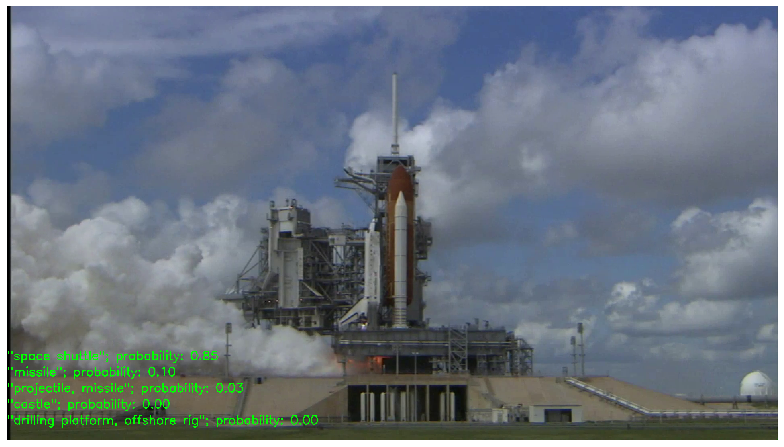

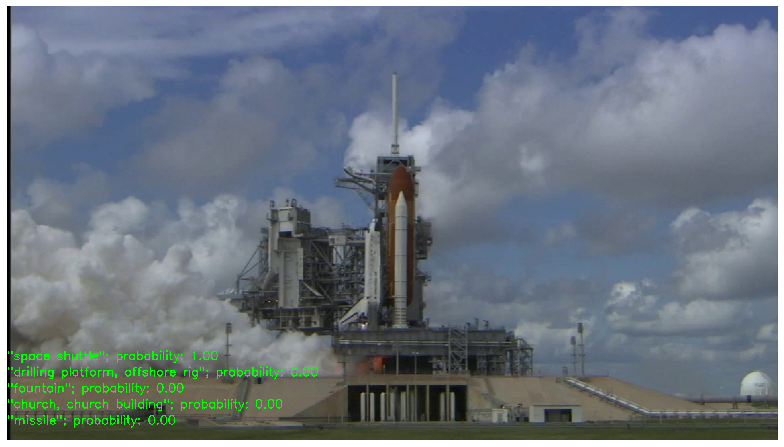

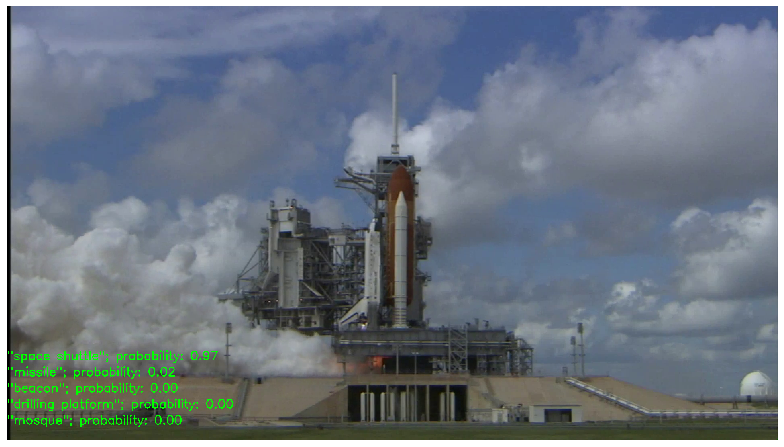

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step1: Define a classify function that takes frames from the video,
#        converts them into tensors,
#        provides them to NN, and
#        selects the five most plausible categories.
def classify(video_src, net, in_layer, out_layer, 
             mean_val, category_names, swap_channels=False):
    cap = cv2.VideoCapture(video_src)

    t = 0
    
    while True:
        status_cap, frame = cap.read()
        if not status_cap:
            break

        if isinstance(mean_val, np.ndarray):
            tensor = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), 1.0, False)
            tensor -= mean_val
        else:
            tensor = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), mean_val, swap_channels)
            
        net.setInput(tensor, in_layer)
        prob = net.forward(out_layer)

        prob = prob.flatten()

        r = 1
        for i in np.argsort(prob)[-5:]:
            txt = '"%s"; probability: %.2f' % (category_names[i], prob[i])
            cv2.putText(frame, txt, (0, frame.shape[0] - r*40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            r += 1

        cv2.imshow('classification', frame)
        if cv2.waitKey(1) == 27: #ESC
            break
        
    cv2.destroyAllWindows()
    cap.release()
    
    if status_cap:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(11,11))
        plt.axis('off')
        plt.xticks([]), plt.yticks([])
        plt.tight_layout()
        plt.imshow(image)
        plt.show()
        
# Step2: Open file that corresponds to name of the category.
with open('./data/synset_words.txt') as f:
    class_names = [' '.join(l.split(' ')[1: ]).rstrip() for l in f.readlines()]
    
# Step3: Call up the GoogleNet model from Caffe and call the classify function defined in step1.
googlenet_caffe = cv2.dnn.readNetFromCaffe('./data/bvlc_googlenet.prototxt', 
                                           './data/bvlc_googlenet.caffemodel')

classify('./data/shuttle.mp4', googlenet_caffe, 'data', 'prob', (104, 117, 123), class_names)

# Step4: Open the ResNet-50 model again in Caffe,
#        load tensor with average value and
#        call the classify function again.
resnet_caffe = cv2.dnn.readNetFromCaffe('./data/resnet_50.prototxt', 
                                           './data/resnet_50.caffemodel')
mean = np.load('./data/resnet_50_mean.npy')

classify('./data/shuttle.mp4', resnet_caffe, 'data', 'prob', mean, class_names)

# Step5: Call up trained GoogleNet models from Tensorflow and category names and
#        perform classification for each frame in the video.
with open('./data/imagenet_comp_graph_label_strings.txt') as f:
    class_names = [l.rstrip() for l in f.readlines()]

googlenet_tf = cv2.dnn.readNetFromTensorflow('./data/tensorflow_inception_graph.pb')

classify('./data/shuttle.mp4', googlenet_tf, 
         'input', 'softmax2', 117, class_names, True)

## 7. Detecting objects with Single Shot Detection (SSD) model

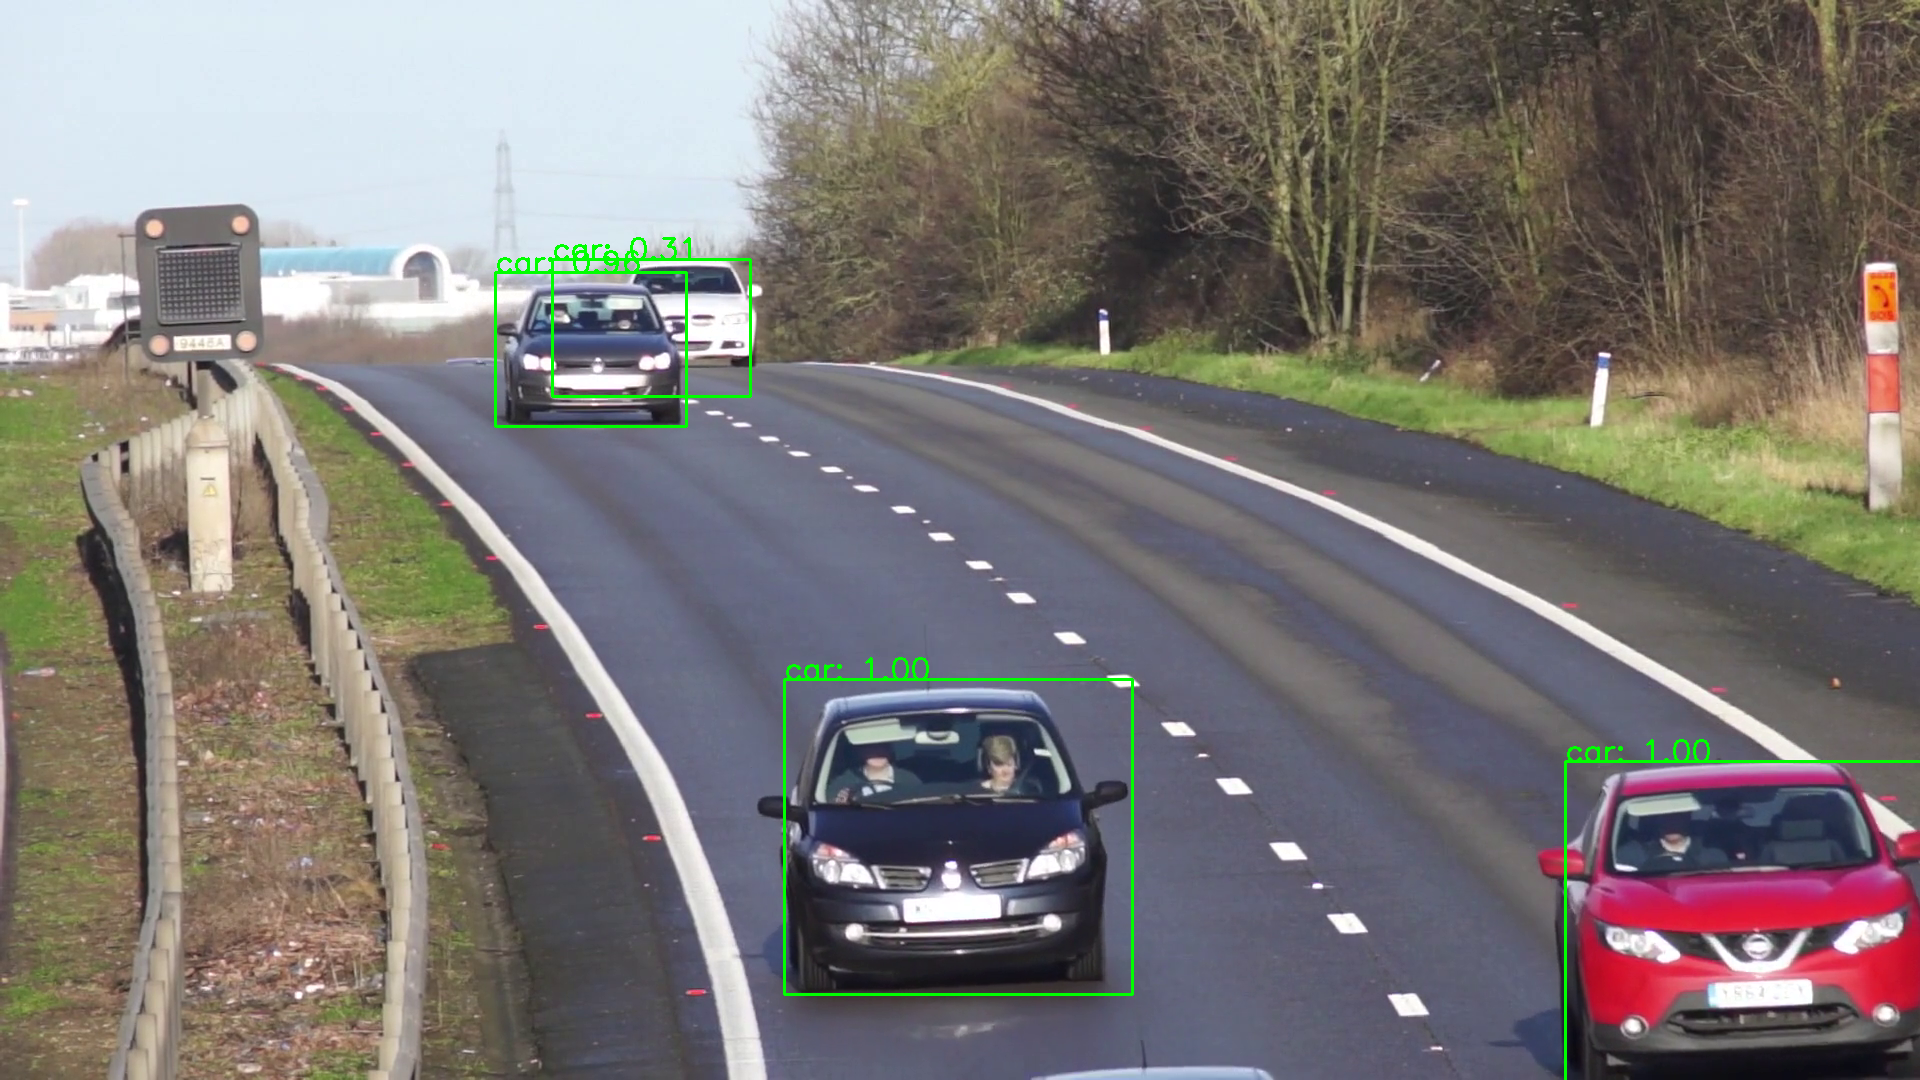

In [7]:
import cv2
import numpy as np
from IPython.display import Image

model = cv2.dnn.readNetFromCaffe('./data/MobileNetSSD_deploy.prototxt',
                                 './data/MobileNetSSD_deploy.caffemodel')

CONF_THR = 0.3
LABELS = {1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat',
          5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair',
          10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse',
          14: 'motorbike', 15: 'person', 16: 'pottedplant',
          17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}

video = cv2.VideoCapture('./data/traffic.mp4')

c=0
while True:
    ret, frame = video.read()
    if not ret: break
        
    h, w = frame.shape[0:2]
    blob = cv2.dnn.blobFromImage(frame, 1/127.5, (300*w//h,300),
                                 (127.5,127.5,127.5), False)
    model.setInput(blob)
    output = model.forward()
    
    for i in range(output.shape[2]):
        conf = output[0,0,i,2]
        if conf > CONF_THR:
            label = output[0,0,i,1]
            x0,y0,x1,y1 = (output[0,0,i,3:7] * [w,h,w,h]).astype(int)
            cv2.rectangle(frame, (x0,y0), (x1,y1), (0,255,0), 2)
            cv2.putText(frame, '{}: {:.2f}'.format(LABELS[label], conf), 
                        (x0,y0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    c += 1
    if c == 100:
        cv2.imwrite('./data/figures/ch5_car_detections.png', frame)
    
    cv2.imshow('frame', frame)
    key = cv2.waitKey(3)
    if key == 27: #ESC
        break
        
cv2.destroyAllWindows()
Image(filename='./data/figures/ch5_car_detections.png', width=550)

## 8. Segmenting scene using Fully Convolutional Network (FCN) model

(1, 21, 600, 800)
(600, 800)


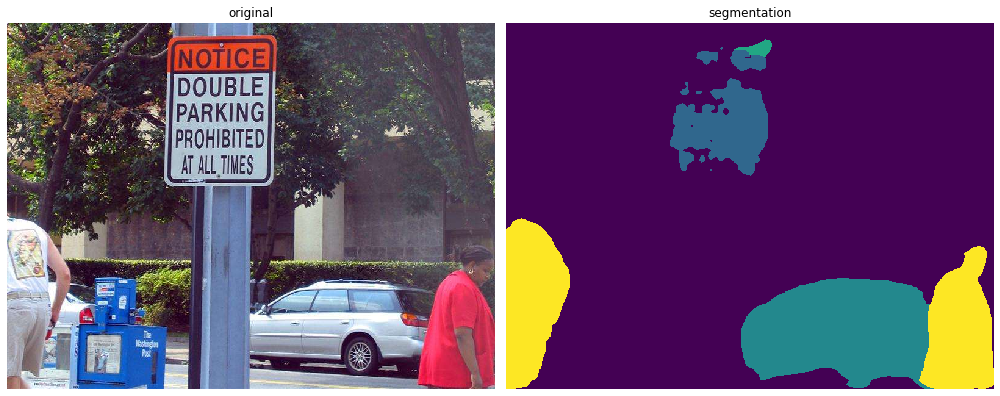

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Download model weights
# http://dl.caffe.berkeleyvision.org/fcn8s-heavy-pascal.caffemodel
model = cv2.dnn.readNetFromCaffe('./data/fcn8s-heavy-pascal.prototxt',
                                 './data/fcn8s-heavy-pascal.caffemodel')

frame = cv2.imread('./data/scenetext01.jpg')
blob = cv2.dnn.blobFromImage(frame, 1, (frame.shape[1],frame.shape[0]))
model.setInput(blob)
output = model.forward()
print(output.shape)

# Compute image with class labels in pixels.
labels = output[0].argmax(0)
print(labels.shape)

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.title('original')
plt.imshow(frame[:,:,[2,1,0]])
plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.title('segmentation')
plt.imshow(labels)
plt.tight_layout()
plt.show()

## 9. Face recognition using SSD and ResNet-10 model

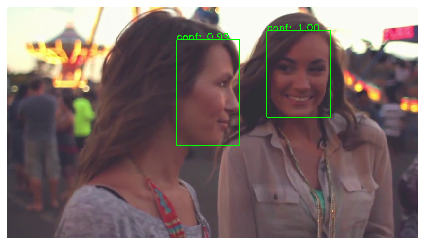

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

model = cv2.dnn.readNetFromCaffe('./data/face_detector/deploy.prototxt', 
                                 './data/face_detector/res10_300x300_ssd_iter_140000.caffemodel')
CONF_THR = 0.5

video = cv2.VideoCapture('./data/faces.mp4')
c = 0
while True:
    ret, frame = video.read()
    if not ret:
        break
        
    h, w = frame.shape[0:2]
    blob = cv2.dnn.blobFromImage(frame, 1, (300*w//h,300), (104,177,123), False)
    model.setInput(blob)
    output = model.forward()
    
    for i in range(output.shape[2]):
        conf = output[0,0,i,2]
        if conf > CONF_THR:
            label = output[0,0,i,1]
            x0,y0,x1,y1 = (output[0,0,i,3:7] * [w,h,w,h]).astype(int)
            cv2.rectangle(frame, (x0,y0), (x1,y1), (0,255,0), 2)
            cv2.putText(frame, 'conf: {:.2f}'.format(conf), (x0,y0),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    c += 1
    if c == 60:
        cv2.imwrite('./data/figures/ch5_face_detections.png', frame)
    
    cv2.imshow('frame', frame)
    key = cv2.waitKey(10) #Speed
    if key == 27: #ESC
        break
        
cv2.destroyAllWindows()
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 10. Age and gender prediction

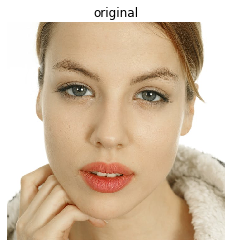

(1, 3, 256, 256) float64
Gender: female with prob: 0.9999792575836182
Age group: (8, 12) with prob: 0.6521071195602417


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step1: Call models
age_model = cv2.dnn.readNetFromCaffe('./data/age_gender/age_net_deploy.prototxt',
                                     './data/age_gender/age_net.caffemodel')
gender_model = cv2.dnn.readNetFromCaffe('./data/age_gender/gender_net_deploy.prototxt',
                                        './data/age_gender/gender_net.caffemodel')

# Step2: Bring up the original image and cut it to required size.
orig_frame = cv2.imread('./data/face.jpeg')
dx = (orig_frame.shape[1]-orig_frame.shape[0]) // 2
orig_frame = orig_frame[:,dx:dx+orig_frame.shape[0]]

# Step3: Visualize
plt.figure(figsize=(4,4))
#image = cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB)
plt.title('original')
plt.axis('off')
plt.xticks([]), plt.yticks([])
#plt.tight_layout()
plt.imshow(orig_frame[:,:,[2,1,0]])
plt.show()

# Step4: Original image - Image recalled with average pixel value
#        Average value per pixel was subtracted from the original image
#        instead of value per channel. In fact,
#        you can see average human face by visualizing the average value.
mean_blob = np.load('./data/age_gender/mean.npy')
print(mean_blob.shape, mean_blob.dtype)
frame = cv2.resize(orig_frame, (256,256)).astype(np.float32)
frame -= np.transpose(mean_blob[0], (1,2,0))

# Step5: Set age & gender list
AGE_LIST = ['(0, 2)','(4, 6)','(8, 12)','(15, 20)',
            '(25, 32)','(38, 43)','(48, 53)','(60, 100)']
GENDER_LIST = ['male','female']

# Step6: Classify gender
blob = cv2.dnn.blobFromImage(frame, 1, (256,256))
gender_model.setInput(blob)
gender_prob = gender_model.forward()
gender_id = np.argmax(gender_prob)
print('Gender: {} with prob: {}'.format(GENDER_LIST[gender_id], gender_prob[0, gender_id]))

# Step7: Classify by age group
age_model.setInput(blob)
age_prob = age_model.forward()
age_id = np.argmax(age_prob)
print('Age group: {} with prob: {}'.format(AGE_LIST[age_id], age_prob[0, age_id]))